<a href="https://colab.research.google.com/github/jinkim-com/qm2coursework/blob/main/NLP_Trump_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture
!pip install spacy
!pip install scattertext
!pip install tika
!pip install spacytextblob
!pip install gensim
!pip install scikit-learn
!pip install torch
!pip install scipy
!python -m spacy download en_core_web_sm
!pip install contractions

import spacy
import json
import pylab
from IPython.core.display import display, HTML
import nltk
from tika import parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spacytextblob.spacytextblob import SpacyTextBlob
import re
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import string
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import string

# Download stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))



%matplotlib inline
pylab.rcParams['figure.figsize'] = (10., 8.)
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')
nltk.download('punkt_tab')


# Linking files and downloads from GitHub


In [3]:
url = "https://raw.githubusercontent.com/jinkim-com/qm2coursework/refs/heads/main/Trump_2020.csv"
df = pd.read_csv(url)

# Cleaning the Data

**Our data may still has some unwanted characters such as \n. This means we need to clean the data:**


In [4]:
# Removing all isntances of \n

df['Speech'] = df['Speech'].str.replace('\n', '', regex=False)

We also need to check that all the speeches are before the election (and are therefore part of the campaign). We can then remove unwanted speeches from the data.

In [5]:
df.sort_values(by=['Date'], inplace=True, ascending=False)
df.head()

Speech     Date
19  Well, thank you very much and I’m thrilled to ...   8/9/20
18  Well, thank you very much. Thank you.Thank you...   8/9/20
34  Hello, everybody. Hello, Duluth. Hello, Duluth...  30/9/20
1    I worked so hard for this state. I worked so ...  30/1/20
17  So thank you Pennsylvania, very much. I’m thri...   3/9/20

# Using contexual embedding techniques to find the words associated with a main word

We are using a pre-trained model in order to find the words most associated with our voter issues. These words are then classified as the regular expressions (RegEx) that we are searching for within the speeches. Instead of using Word2Vec, we are using GloVe, which is more lightweight. This means it is faster and a smaller download which is good for GitHub, but nonetheless effective.

In [6]:
from gensim.downloader import load

# Load the GloVe model (100-dimensional)
glove_model = load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [7]:
# Size of the vocabulary
print(f"Vocabulary size: {len(glove_model.index_to_key)}")

# Dimension of word vectors
print(f"Vector size: {glove_model.vector_size}")


Vocabulary size: 400000
Vector size: 100


In [8]:
def format_results(results):
    return "\n".join([f"{i+1}. {word} (Similarity: {similarity:.4f})"
                      for i, (word, similarity) in enumerate(results)])

# Function to find top 10 similar words to a single word
def find_similar_single(word, topn=10):
    if word in glove_model:
        results = glove_model.most_similar(positive=[word], topn=topn)
        print(f"Top {topn} words similar to '{word}':\n" + format_results(results)+ "\n")
        return [word for word, _ in results]
    else:
        print(f"Word '{word}' not found in the model vocabulary.")

# Function to find top 10 similar words to a combination of two words
def find_similar_combination(word1, word2, topn=10):
    missing_words = [word for word in [word1, word2] if word not in glove_model]
    if missing_words:
        print(f"The following words are not in the vocabulary: {', '.join(missing_words)}")
        return [word for word, _ in results]

    results = glove_model.most_similar(positive=[word1, word2], topn=topn)
    print((f"Top {topn} words similar to the combination of '{word1}' + '{word2}':\n"
            + format_results(results))+"\n")

In [9]:
economy_top10 = find_similar_single('economy')
healthcare_top10 = find_similar_single('healthcare')
crime_top10 = find_similar_single('crime')
foreign_policy_top10 = find_similar_combination('foreign', 'policy')
immigration_top10 = find_similar_single('immigration')

Top 10 words similar to 'economy':
1. economic (Similarity: 0.8279)
2. growth (Similarity: 0.7947)
3. recession (Similarity: 0.7692)
4. economies (Similarity: 0.7545)
5. recovery (Similarity: 0.7491)
6. downturn (Similarity: 0.7462)
7. slowdown (Similarity: 0.7368)
8. slowing (Similarity: 0.7281)
9. sector (Similarity: 0.7247)
10. crisis (Similarity: 0.7136)

Top 10 words similar to 'healthcare':
1. health (Similarity: 0.7659)
2. care (Similarity: 0.7575)
3. services (Similarity: 0.6494)
4. medicare (Similarity: 0.6475)
5. medical (Similarity: 0.6411)
6. insurance (Similarity: 0.6283)
7. education (Similarity: 0.6249)
8. provider (Similarity: 0.6174)
9. providers (Similarity: 0.6123)
10. medicaid (Similarity: 0.6097)

Top 10 words similar to 'crime':
1. criminal (Similarity: 0.7859)
2. crimes (Similarity: 0.7696)
3. murder (Similarity: 0.6961)
4. trafficking (Similarity: 0.6934)
5. terrorism (Similarity: 0.6890)
6. homicide (Similarity: 0.6839)
7. corruption (Similarity: 0.6802)
8. cri

# Finding the frequency of regular expressions affliated with voter issues

In [30]:
# We created a function that will take a list of words which are affliated with topics of voter importance and display a table of how many times they collectively occcur in each speech.

def count_words(words) :
    # Creating a table which shows the date and frequency of the words being used
    df[f'{words[0]}'] = df['Speech'].apply(lambda x: sum(len(re.findall(r'\b' + word + r'\b', x, re.IGNORECASE)) for word in words))
    print(df[['Date',f'{words[0]}']])
    capitalised_words = [word.capitalize() for word in words]
    title = capitalised_words[0]
    return df[['Date',f'{words[0]}']]

    # Creating the graph
    df['Date'] = pd.to_datetime(df['Date']) # Convert 'Date' column to datetime
    df['Month'] = df['Date'].dt.month
    monthly=df.groupby('Month')[f'{words[0]}'].sum()
    monthly.plot()
    plt.xlabel("Month")
    plt.ylabel(f"No. of times the {title} was mentioned")
    plt.title(f"Frequency of {title} mentioned in Trump's campaign speeches in 2016")


         Date  economic
19 2020-08-09         0
18 2020-08-09         2
34 2020-09-30         2
1  2020-01-30         3
17 2020-03-09         3
16 2020-08-28         1
6  2020-02-28         0
0  2020-01-28         1
33 2020-09-27         2
15 2020-08-27         5
32 2020-09-26         1
31 2020-09-25         1
30 2020-09-24         4
14 2020-08-24         2
9  2020-06-23         0
29 2020-09-22         2
27 2020-09-21         4
28 2020-09-21         1
8  2020-06-21         2
5  2020-02-21         1
4  2020-02-21         0
13 2020-08-20         1
3  2020-02-20         1
7  2020-02-03         0
26 2020-09-19         2
25 2020-09-18         0
24 2020-09-17         3
12 2020-08-17         7
11 2020-08-17         4
40 2020-10-16         1
39 2020-10-15        14
23 2020-09-14         5
10 2020-08-14         0
38 2020-10-14         4
22 2020-09-13         3
37 2020-10-13         8
21 2020-12-09         6
36 2020-12-10         2
20 2020-10-09         1
2  2020-10-02         0
35 2020-10-10   

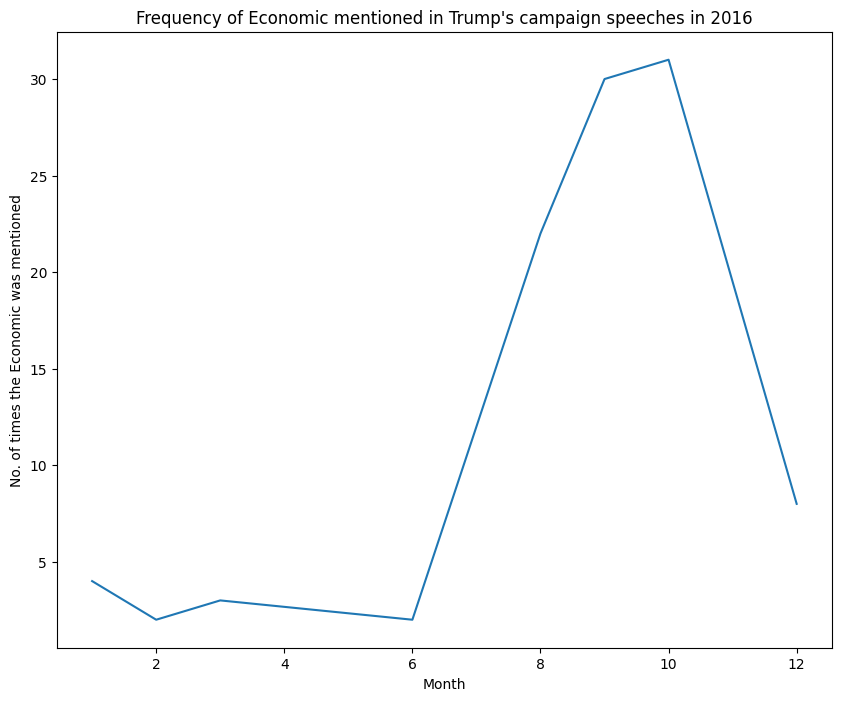

In [38]:
words = count_words(economy_top10)

         Date  terrorism
19 2020-08-09          0
18 2020-08-09          4
34 2020-09-30          3
1  2020-01-30          2
17 2020-03-09          1
16 2020-08-28          2
6  2020-02-28          1
0  2020-01-28          2
33 2020-09-27          2
15 2020-08-27          3
32 2020-09-26          2
31 2020-09-25          0
30 2020-09-24          3
14 2020-08-24          0
9  2020-06-23          0
29 2020-09-22          2
27 2020-09-21          3
28 2020-09-21          0
8  2020-06-21          0
5  2020-02-21          1
4  2020-02-21          1
13 2020-08-20          2
3  2020-02-20          1
7  2020-02-03          5
26 2020-09-19          1
25 2020-09-18          4
24 2020-09-17          3
12 2020-08-17          1
11 2020-08-17          0
40 2020-10-16          0
39 2020-10-15          2
23 2020-09-14          0
10 2020-08-14          0
38 2020-10-14          3
22 2020-09-13          4
37 2020-10-13          3
21 2020-12-09          4
36 2020-12-10          3
20 2020-10-09          2


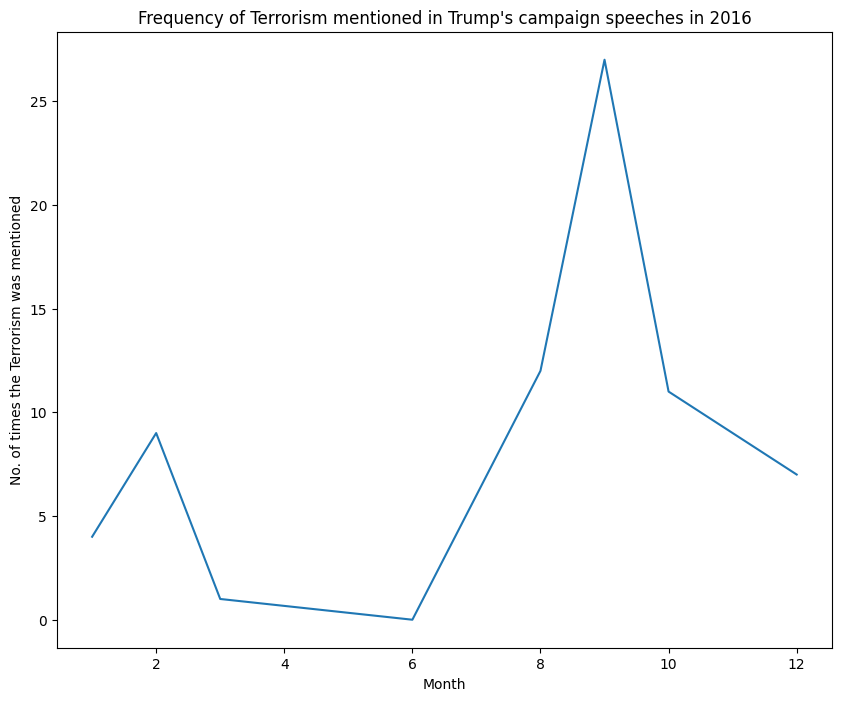

In [12]:
terrorism_words = ['terrorism', 'terrorists', 'attacks']
count_words(terrorism_words)

         Date  Supreme Court
19 2020-08-09              0
18 2020-08-09              0
34 2020-09-30              5
1  2020-01-30              1
17 2020-03-09              0
16 2020-08-28              1
6  2020-02-28              0
0  2020-01-28              2
33 2020-09-27              5
15 2020-08-27              1
32 2020-09-26              8
31 2020-09-25              2
30 2020-09-24              4
14 2020-08-24              2
9  2020-06-23              3
29 2020-09-22              8
27 2020-09-21              9
28 2020-09-21              8
8  2020-06-21              6
5  2020-02-21              1
4  2020-02-21              3
13 2020-08-20              2
3  2020-02-20              3
7  2020-02-03              1
26 2020-09-19             10
25 2020-09-18              5
24 2020-09-17              1
12 2020-08-17              1
11 2020-08-17              0
40 2020-10-16              2
39 2020-10-15             11
23 2020-09-14              0
10 2020-08-14              0
38 2020-10-14 

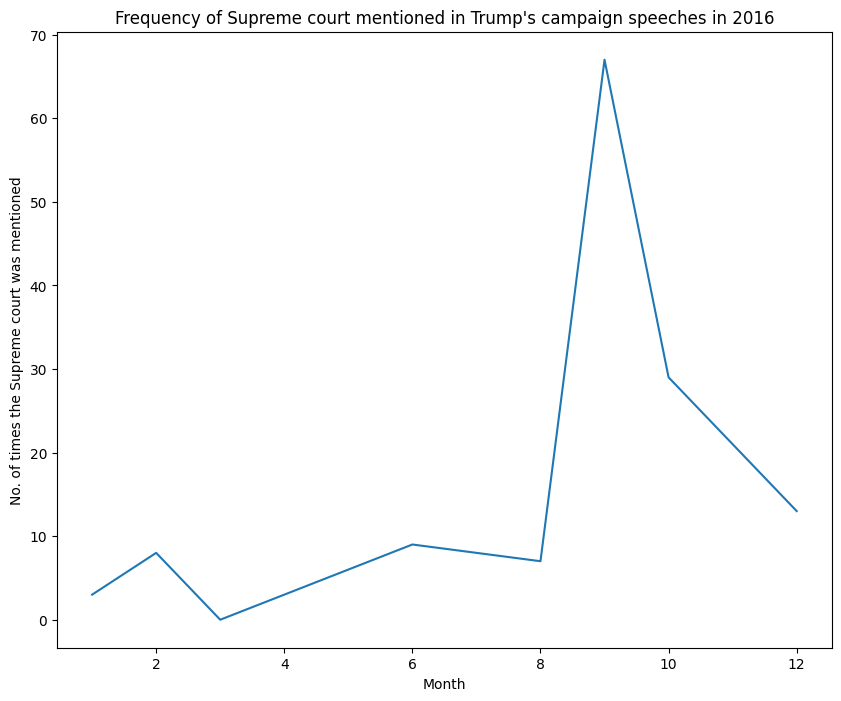

In [13]:
supreme_court_words = ['Supreme Court', 'Supreme Court Justice', 'Stras']
count_words(supreme_court_words)

         Date  Healthcare
19 2020-08-09           0
18 2020-08-09           8
34 2020-09-30           4
1  2020-01-30          20
17 2020-03-09          10
16 2020-08-28           6
6  2020-02-28          15
0  2020-01-28           3
33 2020-09-27          11
15 2020-08-27           4
32 2020-09-26           8
31 2020-09-25           3
30 2020-09-24          11
14 2020-08-24           5
9  2020-06-23          10
29 2020-09-22          15
27 2020-09-21           6
28 2020-09-21           8
8  2020-06-21          12
5  2020-02-21           5
4  2020-02-21          26
13 2020-08-20           3
3  2020-02-20          15
7  2020-02-03          12
26 2020-09-19          19
25 2020-09-18           3
24 2020-09-17          11
12 2020-08-17           7
11 2020-08-17           7
40 2020-10-16          14
39 2020-10-15          11
23 2020-09-14           0
10 2020-08-14           0
38 2020-10-14           6
22 2020-09-13           4
37 2020-10-13          11
21 2020-12-09          12
36 2020-12-1

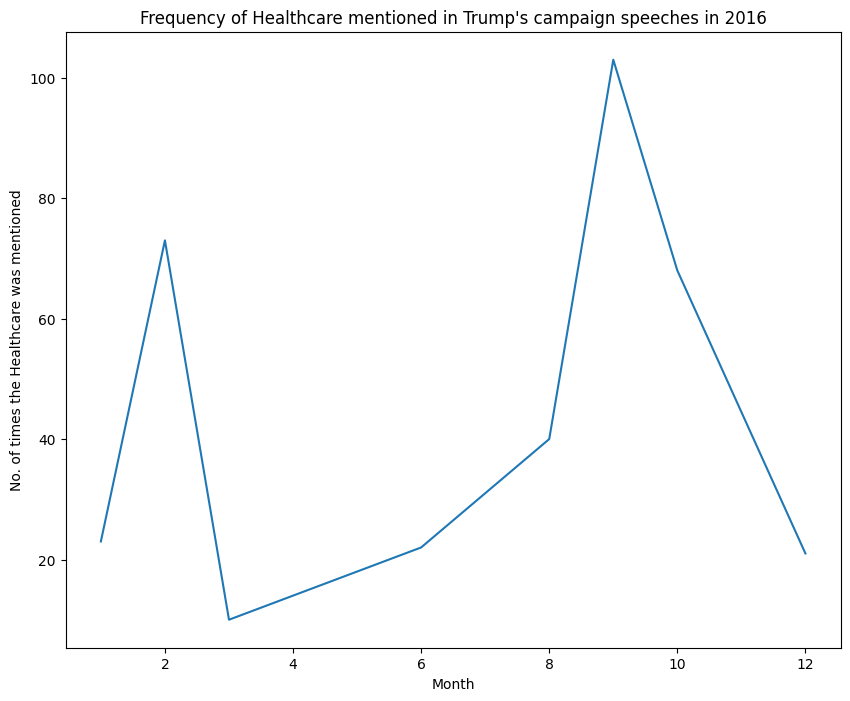

In [14]:
healthcare_words = ['Healthcare', 'Affordable Care Act', 'COVID', 'vaccine', 'coronavirus', 'Obamacare', 'health insurance']
count_words(healthcare_words)

         Date  Foreign Policy
19 2020-08-09               4
18 2020-08-09              36
34 2020-09-30              10
1  2020-01-30              22
17 2020-03-09              36
16 2020-08-28              28
6  2020-02-28               3
0  2020-01-28               1
33 2020-09-27              20
15 2020-08-27              18
32 2020-09-26               7
31 2020-09-25               4
30 2020-09-24              15
14 2020-08-24              26
9  2020-06-23              13
29 2020-09-22              13
27 2020-09-21              10
28 2020-09-21              56
8  2020-06-21              13
5  2020-02-21              10
4  2020-02-21              11
13 2020-08-20              14
3  2020-02-20               6
7  2020-02-03               1
26 2020-09-19              41
25 2020-09-18              19
24 2020-09-17              42
12 2020-08-17              41
11 2020-08-17              34
40 2020-10-16               4
39 2020-10-15              20
23 2020-09-14               3
10 2020-08

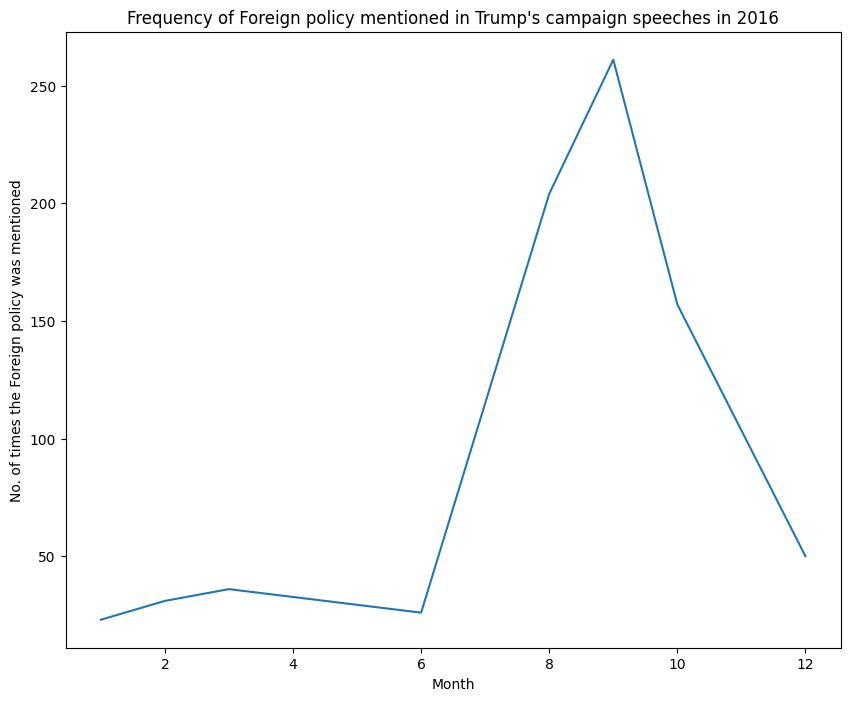

In [15]:
foreign_policy_words = ['Foreign Policy', 'tariffs', 'China', 'Putin', 'Xi']
count_words(foreign_policy_words)

# Finding average sentence length

In [16]:
# We created a function to find the length of each sentence
def sentence_length():
    for speech in df['Speech']:
        all_sentence_lengths = []
        doc = nlp(speech)
        for sentence in doc.sents:
            # Exclude the full stop from the word count
            num_words = len([token for token in sentence if not token.is_punct])
            all_sentence_lengths.append(num_words)

    return all_sentence_lengths

# Creating a table of summary statistics for the sentence lengths
word_count = pd.Series(sentence_length())
summary_stats = word_count.describe().to_frame().T
summary_stats.index = ['Sentence Length (Words)']

print(summary_stats)

                         count       mean       std  min  25%  50%   75%   max
Sentence Length (Words)  266.0  10.921053  8.858924  1.0  5.0  8.0  14.0  49.0


In [17]:
def avg_sentence_length_per_speech(df):
    speech_sentence_lengths = []
    for speech in df['Speech']:
        sentences = nltk.sent_tokenize(speech)  # Sentence segmentation with NLTK
        sentence_lengths = [len(nltk.word_tokenize(sentence)) for sentence in sentences]
        avg_length = np.mean(sentence_lengths) if sentence_lengths else 0  # Handle empty speeches
        speech_sentence_lengths.append(avg_length)

    return pd.Series(speech_sentence_lengths, index=df.index)

avg_lengths_series = avg_sentence_length_per_speech(df)

# We then created a new column in the dataframe with the Average Sentence Length per Speech
df['Mean Sentence Length (Words)'] = avg_lengths_series
# df = df.drop(columns=['Mean Sentence Length(Words)'])

sent_summary_stats = df['Mean Sentence Length (Words)'].describe().to_frame().T
sent_summary_stats.index = ['Mean Sentence Length (Words)']


In [18]:
sent_summary_stats

count       mean       std        min  \
Mean Sentence Length (Words)   41.0  14.543913  1.674389  12.348837   

                                    25%        50%        75%        max  
Mean Sentence Length (Words)  13.157321  14.300178  15.695712  18.962085





# Analysing Distinguishing Terms


In [19]:
df['Month'] = df['Date'].dt.month
df.head()

Speech       Date  economic  \
19  Well, thank you very much and I’m thrilled to ... 2020-08-09         0   
18  Well, thank you very much. Thank you.Thank you... 2020-08-09         2   
34  Hello, everybody. Hello, Duluth. Hello, Duluth... 2020-09-30         2   
1    I worked so hard for this state. I worked so ... 2020-01-30         3   
17  So thank you Pennsylvania, very much. I’m thri... 2020-03-09         3   

    Month  terrorism  Supreme Court  Healthcare  Foreign Policy  \
19      8          0              0           0               4   
18      8          4              0           8              36   
34      9          3              5           4              10   
1       1          2              1          20              22   
17      3          1              0          10              36   

    Mean Sentence Length (Words)  
19                     18.962085  
18                     15.787975  
34                     13.054545  
1                      14.961690  
17                     14.728926

In [20]:
import scattertext as st

# create a corpus of text from the dataframe
corpus = st.CorpusFromPandas(df, # load the dataframe
                             category_col='Month', # indicate which column contains the category we want to distinguish by
                             text_col='Speech', # indicate which column stores the text to be analyzed
                             nlp=nlp).build() # load the NLP models used for analysis

# remove stopwords from the corpus of text
corpus=corpus.remove_terms(nlp.Defaults.stop_words, ignore_absences=True)

# now, we create the scatterplot
html = st.produce_scattertext_explorer(
                   corpus, # load the corpus
                   category="8", # indicate which category value we want to compare against all others; in this case, all rows in which "REX TILLERSON" is the speaker
                   category_name='August', # set the label on the plot as "Rex Tillerson"
                   not_category_name='Others', # set the label on the plot for all other speakers as "Others"
                   width_in_pixels=1000) #set the width

In [21]:
# display the plot
display(HTML(html))

# Sentiment Analysis

In [22]:
def get_sentiment_scores_batch(texts):
    docs = nlp.pipe(texts)  # Process all texts in batch
    polarity_scores = [doc._.blob.polarity for doc in docs]
    return polarity_scores
# Apply the function to the 'Speech' column and create new columns
df['Polarity'] = get_sentiment_scores_batch(df['Speech']) # Assign the results directly to 'Polarity' column
df.head()


Speech       Date  economic  \
19  Well, thank you very much and I’m thrilled to ... 2020-08-09         0   
18  Well, thank you very much. Thank you.Thank you... 2020-08-09         2   
34  Hello, everybody. Hello, Duluth. Hello, Duluth... 2020-09-30         2   
1    I worked so hard for this state. I worked so ... 2020-01-30         3   
17  So thank you Pennsylvania, very much. I’m thri... 2020-03-09         3   

    Month  terrorism  Supreme Court  Healthcare  Foreign Policy  \
19      8          0              0           0               4   
18      8          4              0           8              36   
34      9          3              5           4              10   
1       1          2              1          20              22   
17      3          1              0          10              36   

    Mean Sentence Length (Words)  Polarity  
19                     18.962085  0.243090  
18                     15.787975  0.163156  
34                     13.054545  0.159592  
1                      14.961690  0.160330  
17                     14.728926  0.145187

In [23]:
sorted_polarity = df.sort_values(by=['Polarity'], ascending=False)
sorted_polarity.head()

Speech       Date  economic  \
23  The fake news, they said that this is supposed... 2020-09-14         5   
19  Well, thank you very much and I’m thrilled to ... 2020-08-09         0   
11  Well hello Oshkosh. Wow! I don’t know what hap... 2020-08-17         4   
35   Well, thank you very much and keep that enthu... 2020-10-10         3   
39  Thank you very much. Thank you. Let’s see, it’... 2020-10-15        14   

    Month  terrorism  Supreme Court  Healthcare  Foreign Policy  \
23      9          0              0           0               3   
19      8          0              0           0               4   
11      8          0              0           7              34   
35     10          0              0           8               6   
39     10          2             11          11              20   

    Mean Sentence Length (Words)  Polarity  
23                     12.489362  0.265866  
19                     18.962085  0.243090  
11                     13.974160  0.207018  
35                     14.926087  0.204489  
39                     14.300178  0.194689

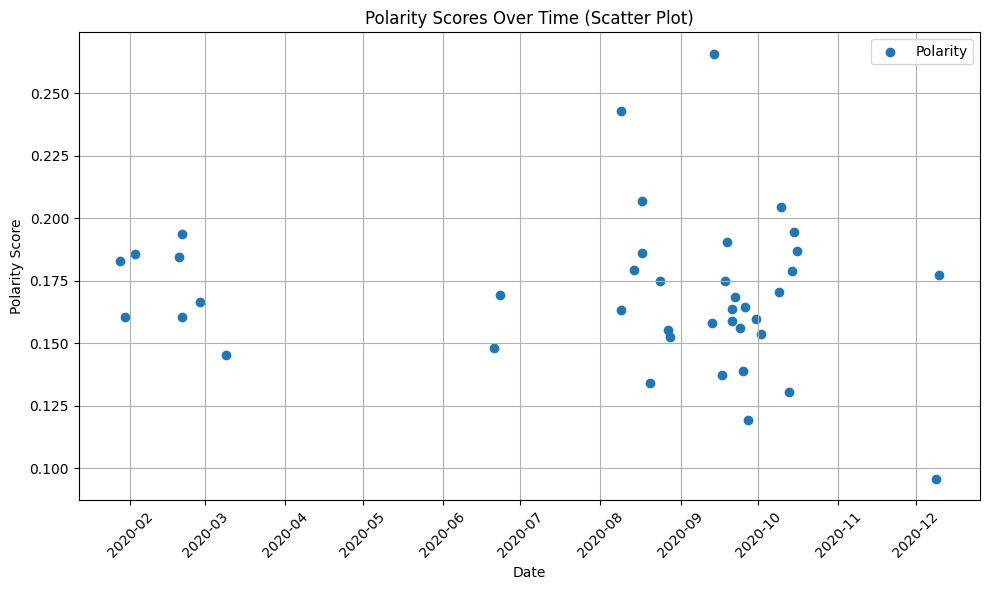

In [24]:
# Ensure 'Date' column is of datetime type:
df['Date'] = pd.to_datetime(df['Date'])

# Create the scatter plot:
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(df['Date'], df['Polarity'], label='Polarity')

# Customize the plot:
plt.xlabel('Date')
plt.ylabel('Polarity Score')
plt.title('Polarity Scores Over Time (Scatter Plot)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot:
plt.show()

# Topic Modelling: LDA Method

In [25]:
all_speeches_text = " ".join(df['Speech'].tolist())

In [26]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
!pip install contractions

# Sample multi-document corpus
documents = df['Speech']

expanded_documents = [expand_contractions(doc) for doc in documents]

# Preprocessing and vectorization pipeline
vectorizer = CountVectorizer(stop_words='english', lowercase=True)
X = vectorizer.fit_transform(documents)

# Apply NMF with adjusted max_iter and tol
nmf = NMF(n_components=10, max_iter=1000, tol=1e-4, init='nndsvd', random_state=42)  # Increased max_iter and set init method
nmf.fit(X)

# Get the feature names (words)
words = vectorizer.get_feature_names_out()

# Function to find the words most affiliated with a given input word
def find_affiliated_words(input_word, nmf, vectorizer, n_top_words=10):
    if input_word not in vectorizer.get_feature_names_out():
        print(f"The word '{input_word}' is not in the vocabulary.")
        return

    word_index = vectorizer.get_feature_names_out().tolist().index(input_word)
    topic_word_dist = nmf.components_

    topic_weights = topic_word_dist[:, word_index]
    most_affiliated_topic = np.argmax(topic_weights)

    print(f"The word '{input_word}' is most affiliated with Topic #{most_affiliated_topic + 1}")

    # Get the top words for this topic
    top_word_indices = topic_word_dist[most_affiliated_topic].argsort()[:-n_top_words - 1:-1]
    top_words = [words[i] for i in top_word_indices]

    output = print(f"Words most affiliated with '{input_word}': {top_words}")

    return output



find_affiliated_words("economy", nmf, vectorizer)

NameError: name 'expand_contractions' is not defined

In [ ]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import contractions

# Function to expand contractions before passing to CountVectorizer
def expand_contractions(text):
    return contractions.fix(text)

# Sample multi-document corpus
documents = df['Speech']

# Expand contractions in the documents
expanded_documents = [expand_contractions(doc) for doc in documents]

# Preprocessing and vectorization pipeline
vectorizer = CountVectorizer(stop_words='english', lowercase=True)
X = vectorizer.fit_transform(expanded_documents)

# Apply NMF with adjusted max_iter and tol
nmf = NMF(n_components=5, max_iter=1000, tol=1e-4, init='nndsvd', random_state=42)  # Increased max_iter and set init method
nmf.fit(X)

# Get the feature names (words)
words = vectorizer.get_feature_names_out()

# Function to find the words most affiliated with a given input word
def find_affiliated_words(input_word, nmf, vectorizer, n_top_words=10):
    if input_word not in vectorizer.get_feature_names_out():
        print(f"The word '{input_word}' is not in the vocabulary.")
        return

    word_index = vectorizer.get_feature_names_out().tolist().index(input_word)
    topic_word_dist = nmf.components_

    topic_weights = topic_word_dist[:, word_index]
    most_affiliated_topic = np.argmax(topic_weights)

    print(f"The word '{input_word}' is most affiliated with Topic #{most_affiliated_topic + 1}")

    # Get the top words for this topic
    top_word_indices = topic_word_dist[most_affiliated_topic].argsort()[:-n_top_words - 1:-1]
    top_words = [words[i] for i in top_word_indices]

    return top_words

# Check with 'economy'
top_words_for_economy = find_affiliated_words("economy", nmf, vectorizer)
print("Words most affiliated with 'economy':", top_words_for_economy)

In [ ]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
import numpy as np
import contractions

# Load SpaCy model for POS tagging
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  # Disable unnecessary components for speed

# Function to expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Function to extract nouns and pronouns using SpaCy's pipe()
def filter_nouns_and_pronouns(documents):
    filtered_texts = []
    for doc in nlp.pipe(documents, batch_size=50):  # Process documents in batches
        filtered_tokens = [token.text for token in doc if token.pos_ in {"NOUN", "PRON"} and not token.is_stop]
        filtered_texts.append(" ".join(filtered_tokens))
    return filtered_texts

# Sample multi-document corpus
documents = df['Speech']

# Preprocessing pipeline: expand contractions and filter nouns/pronouns
expanded_documents = [expand_contractions(doc) for doc in documents]
filtered_documents = filter_nouns_and_pronouns(expanded_documents)

# Vectorization
vectorizer = CountVectorizer(stop_words='english', lowercase=True)
X = vectorizer.fit_transform(filtered_documents)

# Apply NMF with adjusted max_iter and tol
nmf = NMF(n_components=5, max_iter=1000, tol=1e-4, init='nndsvd', random_state=42)
nmf.fit(X)

# Get the feature names (words)
words = vectorizer.get_feature_names_out()

# Function to find the words most affiliated with a given input word
def find_affiliated_words(input_word, nmf, vectorizer, n_top_words=10):
    if input_word not in vectorizer.get_feature_names_out():
        print(f"The word '{input_word}' is not in the vocabulary.")
        return

    word_index = vectorizer.get_feature_names_out().tolist().index(input_word)
    topic_word_dist = nmf.components_

    topic_weights = topic_word_dist[:, word_index]
    most_affiliated_topic = np.argmax(topic_weights)

    print(f"The word '{input_word}' is most affiliated with Topic #{most_affiliated_topic + 1}")

    # Get the top words for this topic
    top_word_indices = topic_word_dist[most_affiliated_topic].argsort()[:-n_top_words - 1:-1]
    top_words = [words[i] for i in top_word_indices]

    return top_words



In [ ]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
import numpy as np
import contractions

# Load SpaCy model for POS tagging
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  # Disable unnecessary components for speed

# Function to expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Function to extract nouns and pronouns using SpaCy's pipe()
def filter_nouns_and_pronouns(documents):
    filtered_texts = []
    for doc in nlp.pipe(documents, batch_size=50):  # Process documents in batches
        filtered_tokens = [token.text for token in doc if token.pos_ in {"NOUN", "PRON"} and not token.is_stop]
        filtered_texts.append(" ".join(filtered_tokens))
    return filtered_texts

# Sample multi-document corpus
documents = df['Speech']

# Preprocessing pipeline: expand contractions and filter nouns/pronouns
expanded_documents = [expand_contractions(doc) for doc in documents]
filtered_documents = filter_nouns_and_pronouns(expanded_documents)

# Vectorization
vectorizer = CountVectorizer(stop_words='english', lowercase=True)
X = vectorizer.fit_transform(filtered_documents)

# Apply NMF with adjusted max_iter and tol
nmf = NMF(n_components=5, max_iter=1000, tol=1e-4, init='nndsvd', random_state=42)
nmf.fit(X)

# Get the feature names (words)
words = vectorizer.get_feature_names_out()

# Function to find the words most affiliated with a list of input words
def find_affiliated_words(input_words, nmf, vectorizer, n_top_words=10):
    results = {}
    topic_word_dist = nmf.components_

    for input_word in input_words:
        if input_word not in vectorizer.get_feature_names_out():
            results[input_word] = f"'{input_word}' is not in the vocabulary."
            continue

        word_index = vectorizer.get_feature_names_out().tolist().index(input_word)
        topic_weights = topic_word_dist[:, word_index]
        most_affiliated_topic = np.argmax(topic_weights)

        # Get the top words for this topic
        top_word_indices = topic_word_dist[most_affiliated_topic].argsort()[:-n_top_words - 1:-1]
        top_words = [words[i] for i in top_word_indices]

        results[input_word] = {
            "Most Affiliated Topic": most_affiliated_topic + 1,
            "Top Words": top_words
        }

    return results

# Example: Check with a list of words
input_words = economy_top10
top_words_for_list = find_affiliated_words(input_words, nmf, vectorizer)

# Display results
for word, details in top_words_for_list.items():
    if isinstance(details, str):  # Handle missing words
        print(f"{word}: {details}")
    else:
        print(f"{word} is most affiliated with Topic #{details['Most Affiliated Topic']}")
        print(f"Top words: {', '.join(details['Top Words'])}")
        print()
